In [1]:
from theano.sandbox import cuda
import utils; reload(utils)
from utils import *

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


In [2]:
vgg = Vgg16()

In [3]:
vgg.model.pop()
for layer in vgg.model.layers:
    layer.trainable=False
vgg.model.add(Dense(2, activation = 'softmax'))
vgg.compile()

In [4]:
model = vgg.model

In [5]:
# load previous weights
model.load_weights('data/dogscats/models/finetune3.h5')

# pre-calculating till the flatten layer

In [6]:
layers = model.layers
[index for index,layer in enumerate(layers) if type(layer) is Convolution2D]

[2, 4, 7, 9, 12, 14, 16, 19, 21, 23, 26, 28, 30]

In [7]:
conv_layers = layers[:32]
conv_model = Sequential(conv_layers)

In [8]:
conv_layers

In [9]:
# fully connected layers
fc_layers = layers[32:]

In [10]:
fc_layers

In [11]:
train_batches = get_batches('data/dogscats/train', shuffle=False, batch_size=64)
val_batches = get_batches('data/dogscats/valid', shuffle=False, batch_size=64)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [12]:
val_classes = val_batches.classes
train_classes = train_batches.classes

In [13]:
val_classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [14]:
train_classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [15]:
val_labels = onehot(val_classes)
train_labels = onehot(train_classes)

In [16]:
val_labels

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

In [17]:
train_labels

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

In [18]:
train_precalc = conv_model.predict_generator(train_batches, train_batches.nb_sample)

In [19]:
val_precalc = conv_model.predict_generator(val_batches, val_batches.nb_sample)

# model without dropout

In [20]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [21]:
conv_layers[-1].output_shape

(None, 512, 7, 7)

In [22]:
fc_model = Sequential([
    Flatten(input_shape=(512, 7, 7)),
    Dense(4096, activation = 'relu'),
    Dropout(0.),
    Dense(4096, activation = 'relu'),
    Dropout(0.),
    Dense(2, activation = 'softmax')
])

In [23]:
# copy the weights from the pre-trained model
# since we're removing dropout, we want to half the weights
fc_model.layers[0].set_weights([x/2 for x in model.layers[32].get_weights()])

In [24]:
fc_model.layers[1].set_weights([x/2 for x in model.layers[33].get_weights()])
fc_model.layers[2].set_weights([x/2 for x in model.layers[34].get_weights()])
fc_model.layers[3].set_weights([x/2 for x in model.layers[35].get_weights()])
fc_model.layers[4].set_weights([x/2 for x in model.layers[36].get_weights()])
fc_model.layers[5].set_weights([x/2 for x in model.layers[37].get_weights()])

In [25]:
fc_model.compile(optimizer=RMSprop(lr=0.00001,rho=0.7), # since this is a finely tuned model, it needs to be updated very slowly
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [26]:
fc_model.fit(train_precalc, train_labels, nb_epoch=8, verbose=2, batch_size=64, validation_data = (val_precalc, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/8
31s - loss: 0.2471 - acc: 0.9823 - val_loss: 0.2504 - val_acc: 0.9815
Epoch 2/8
31s - loss: 0.2131 - acc: 0.9852 - val_loss: 0.2648 - val_acc: 0.9815
Epoch 3/8
31s - loss: 0.1610 - acc: 0.9888 - val_loss: 0.2218 - val_acc: 0.9850
Epoch 4/8
31s - loss: 0.1348 - acc: 0.9906 - val_loss: 0.2068 - val_acc: 0.9855
Epoch 5/8
31s - loss: 0.1221 - acc: 0.9916 - val_loss: 0.3051 - val_acc: 0.9800
Epoch 6/8
31s - loss: 0.1036 - acc: 0.9931 - val_loss: 0.2132 - val_acc: 0.9860
Epoch 7/8
31s - loss: 0.0979 - acc: 0.9934 - val_loss: 0.2226 - val_acc: 0.9845
Epoch 8/8
31s - loss: 0.0834 - acc: 0.9946 - val_loss: 0.2074 - val_acc: 0.9855


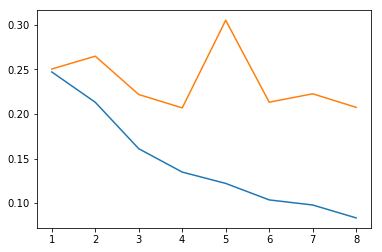

In [28]:
%matplotlib inline
plt.plot(range(1,9), [0.2471, 0.2131, 0.1610, 0.1348, 0.1221, 0.1036, 0.0979, 0.0834],
        range(1,9), [0.2504, 0.2648, 0.2218, 0.2068, 0.3051, 0.2132, 0.2226, 0.2074])

In [29]:
# We are certainly in the overfitting zone

# Data augmentation

In [31]:
gen = image.ImageDataGenerator(rotation_range = 15, width_shift_range = 0.1, height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

In [32]:
train_batches = get_batches('data/dogscats/train', gen, batch_size=64)
val_batches = get_batches('data/dogscats/valid', gen, batch_size=64)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [33]:
for layer in conv_model.layers:
    layer.trainable=False

In [34]:
conv_model.add(Sequential([
    Flatten(input_shape=(512, 7, 7)),
    Dense(4096, activation = 'relu'),
    Dropout(0.),
    Dense(4096, activation = 'relu'),
    Dropout(0.),
    Dense(2, activation = 'softmax')
]))

In [39]:
conv_model.compile(optimizer=RMSprop(lr=0.00001,rho=0.7),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
fit_hist = conv_model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample, nb_epoch=2,verbose=2, validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/2
646s - loss: 0.1973 - acc: 0.9773 - val_loss: 0.2936 - val_acc: 0.9725
Epoch 2/2
644s - loss: 0.1936 - acc: 0.9790 - val_loss: 0.2559 - val_acc: 0.9715


# Batch normalization and Dropout

In [18]:
bn_model = Sequential([
    Flatten(input_shape = (512, 7, 7)),
    Dense(4096, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.6),
    Dense(4096, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.6),
    Dense(2, activation = 'softmax')
])

In [19]:
# load weights for the model from the dense layers of the Vgg16BN model
from vgg16bn import Vgg16BN

In [20]:
vgg16_bn = Vgg16BN()

In [24]:
vgg16_bn.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_14[0][0]           
___________________________________________________________________________________________

In [27]:
bn_model.layers[0]

In [28]:
vgg16_bn.model.layers[32]

In [29]:
bn_model.layers[0].set_weights(vgg16_bn.model.layers[32].get_weights())
bn_model.layers[1].set_weights(vgg16_bn.model.layers[33].get_weights())
bn_model.layers[2].set_weights(vgg16_bn.model.layers[34].get_weights())
bn_model.layers[3].set_weights(vgg16_bn.model.layers[35].get_weights())
bn_model.layers[4].set_weights(vgg16_bn.model.layers[36].get_weights())
bn_model.layers[5].set_weights(vgg16_bn.model.layers[37].get_weights())
bn_model.layers[6].set_weights(vgg16_bn.model.layers[38].get_weights())

In [30]:
# rescaling because the dropout percentages are different for the loaded weights
# only changing for dense layers
bn_model.layers[1].set_weights([x*(1-0.5)/(1-0.6) for x in bn_model.layers[1].get_weights()])
bn_model.layers[4].set_weights([x*(1-0.5)/(1-0.6) for x in bn_model.layers[4].get_weights()])

In [31]:
bn_model.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])